In [1]:
# import packages
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import os
import sys
import hist

# set cms plot style
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")
from setting import setting

In [2]:
#config_path = "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL_alphavalidate_110to135.yml"
year = 2018
import yaml
config_path = f"/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL{year}.yml"
with open( config_path) as f:
    config = yaml.safe_load(f)

In [3]:
#make cut
def make_cut(selection,arr):
    r'''
    input: selection, arr as ak.Aarry()
    output: cuted arr with selection
    '''
    cut  = ak.numexpr.evaluate(selection,arr)
    return arr[cut]

#plot function
def plot_1d_data_mc(hist_dir,case,isdata = False,isdensity = False):
    r'''
        input: hist_dir, case, isdata, isdensity
        output: plot the histograms with hep.histplot
        case = 'resolved' or 'merged'
        isdata = True or False (default False)
        isdensity = True or False (default False)
    '''
    #create a list to stroe all keys in hist_dir as sample names except 'data'
    sample_names = [sample for sample in hist_dir.keys() if sample != 'data']
    #create a list to store all values in hist_dir as the histograms except 'data'
    histo_mc  = [hist_dir[sample] for sample in sample_names]
    #plot the mc histograms via hep.histplot
    #label is the list of sample names with retriving the number of events in each histogram
    #colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown','black']
    labels = ["{} ({})".format(sample,round(hist_dir[sample].values().sum(),4),'.4f') for sample in sample_names]
    if isdensity:
        #hep.histplot(histo_mc,label=labels, density=True,linewidth=1,color = [color for color in colors] )
        hep.histplot(histo_mc,label=labels, density=True,linewidth=1)
    else:
        hep.histplot(histo_mc,stack=True,label=labels,histtype='fill', edgecolor='k', linewidth=1,)
    
    if isdata:
        hep.histplot(hist_dir['Data'],label='Data', color='k', histtype='errorbar', linewidth=1.5,markersize=15)
    #set the x-axis label
    #plt.xlabel('M(2l2q) [GeV]')
    #plt.xlabel('particleNetZvsQCD')
    plt.xlabel('pt(ll)')
    #set the y-axis label
    plt.ylabel('Events')
    #set the legend
    plt.legend(loc='upper right',fontsize=10,fancybox=True,shadow=True)
    #set title with size
    #plt.title(f'Estimate M(2l2q) distribution in SR in {case} category with all possible backgrounds',fontsize=10)
    #plt.title(f'particleNetZvsQCD scroe with ZV process in pt range 600 To Inf GeV',fontsize=10)
    plt.title(f'pt2l',fontsize=10)

In [3]:
year = '2018'

#samples = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf','TTTo2L2Nu','WWTo2L2Nu','WZTo2Q2L','ZZTo2Q2L','WWTo1L1Nu2Q','tZq','ZZTo2L2Nu','WZTo1L1Nu2Q','ggh1000','ggh500','sig','ggh2000']
#samples = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf','TTTo2L2Nu','WWTo2L2Nu','WZTo2Q2L','ZZTo2Q2L','tZq','ggh1000','sig']
#samples = ['TTTo2L2Nu','tZq']
samples = ['ggh125','ggh400','ggh450','ggh500','ggh550','ggh600','ggh700','ggh750','ggh800','ggh900','ggh1000','ggh2000','ggh2500','ggh3000',]
#samples = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf','ggh1000','ggh200','ggh300','ggh500']
#samples = ['TTTo2L2Nu','tZq','WWTo1L1Nu2Q','WZTo1L1Nu2Q','ggh1000','vbf1000','ZZTo2Q2L','WZTo2Q2L']
arr = {}
sumweight = {}
n_events = {}
for sample in samples:
    #arr[sample] = uproot.lazy([f"{setting().fileset[year][sample][0]}:passedEvents"],filter_name = ['jet*','found*','KD*','Met','mass*','isMuMu','isEE'])
    arr[sample] = uproot.lazy([f"{setting().fileset[year][sample][0]}:passedEvents"],filter_name = ['GEN*','p_*'])
    
    f = uproot.open(setting().fileset[year][sample][0])['sumWeights']
    sumweight[sample] = (f.to_boost()).sum()

    f = uproot.open(setting().fileset[year][sample][0])['nEvents']
    n_events[sample] = (f.to_boost()).sum()

    f.close()

### Deepjet uncertainties

In [4]:
from deepjet import DeepJet as dj

In [48]:
arr_cut = {}
selection = config['cut']['SR']['isEE']['resolved']['btag']
for sample in samples:
    arr_cut[sample] = make_cut(selection,arr[sample])

In [52]:
temp_array = ak.concatenate([arr_cut['WZTo1L1Nu2Q'],arr_cut['WZTo2Q2L'],arr_cut['ZZTo2Q2L']])
#temp_array = ak.concatenate([arr_cut['TTTo2L2Nu'],arr_cut['tZq']])
#temp_array = arr_cut['ggh1000']
dj_helper = dj(year,temp_array)
sf_jet1,sf_jet2 = dj_helper.get_deepjet_sf('central')
#compute uncertainty for deepjet SFs.
sf_jet1_up,sf_jet2_up = dj_helper.get_deepjet_sf('up_correlated')
sf_jet1_down,sf_jet2_down = dj_helper.get_deepjet_sf('down_correlated')
sf_certral = (sf_jet1+sf_jet2).sum()
sf_up = (sf_jet1_up+sf_jet2_up).sum()
sf_down = (sf_jet1_down+sf_jet2_down).sum()
uncertainty_up = abs(sf_up-sf_certral)/sf_certral
uncertainty_down = abs(sf_down-sf_certral)/sf_certral

print(f'uncertainty = {1+uncertainty_up}/{1-uncertainty_down}')

uncertainty = 1.0081083873719552/0.9918916126280447


In [5]:
arr['ggh4l400'].fields

KeyError: 'ggh4l400'

### draw some variables for testing

Text(0, 1, 'Unity')

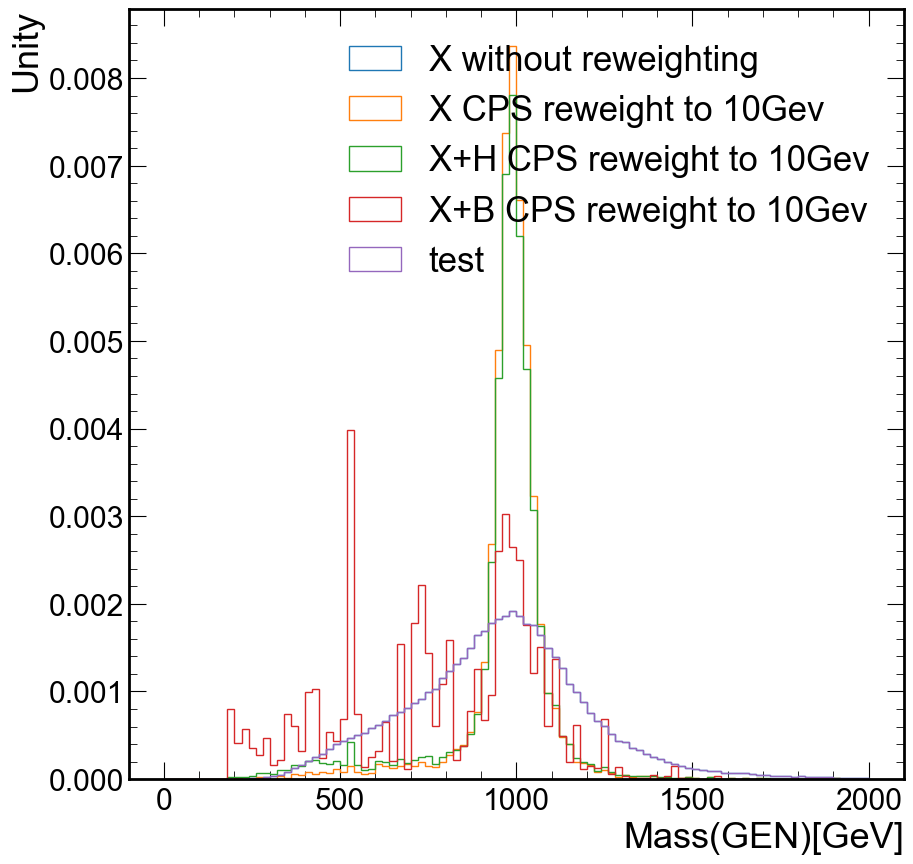

In [4]:
# plot arr[CPStoBW_GaH10_PropRewgt]
sample = 'ggh1000'
ifdensity = True
#temp_array = ak.concatenate([arr['ggh1000'],arr['ggh400']])
temp_array = arr['ggh1000']
min_x_bin = 0; max_x_bin = 2000; n_x_bin = 100
#plt.hist(arr['ggh2000'].GEN_H1_mass, bins=100, range=(0,3000), histtype='step', label='ggh2000',weights=arr['ggh2000'].p_Gen_CPStoBW_GaH200_PropRewgt*arr['ggh2000'].p_Gen_GG_SIG_HM_kappa2TopBot_1_gh2z1_1_MCFM)
plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X without reweighting',   density=ifdensity)
plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X CPS reweight to 10Gev',   density=ifdensity,weights=  temp_array.p_Gen_CPStoBW_GaH10_PropRewgt)
plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+H CPS reweight to 10Gev',   density=ifdensity,weights=  temp_array.p_Gen_CPStoBW_GaH10_PropRewgt*temp_array.p_Gen_GG_SIG_H125_kappaTopBot_1_ghz1_1_HM_kappa2TopBot_1_gh2z1_1_MCFM/temp_array.p_Gen_GG_SIG_HM_kappa2TopBot_1_gh2z1_1_MCFM)
plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+B CPS reweight to 10Gev',   density=ifdensity,weights=  temp_array.p_Gen_CPStoBW_GaH10_PropRewgt*temp_array.p_Gen_GG_BSI_HM_kappa2TopBot_1_gh2z1_1_MCFM/temp_array.p_Gen_GG_SIG_HM_kappa2TopBot_1_gh2z1_1_MCFM)
plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='test',   density=ifdensity,weights=  temp_array.p_Gen_GG_SIG_HM_kappa2TopBot_1_gh2z1_1_MCFM)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X to H ',   density=ifdensity,weights=  temp_array.p_Gen_GG_SIG_H125_kappaTopBot_1_ghz1_1_HM_kappa2TopBot_1_gh2z1_1_MCFM/temp_array.p_Gen_GG_SIG_HM_kappa2TopBot_1_gh2z1_1_MCFM)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+H+B', density=ifdensity,weights=temp_array.p_Gen_CPStoBW_GaH10_PropRewgt*temp_array.p_Gen_GG_SIG_H125_kappaTopBot_1_ghz1_1_MCFM)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+B',   density=ifdensity,weights=  temp_array.p_Gen_CPStoBW_GaH10_PropRewgt*temp_array.p_Gen_GG_BSI_HM_kappa2TopBot_1_gh2z1_1_MCFM)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+B',   density=ifdensity,weights=  temp_array.p_Gen_CPStoBW_GaH10_PropRewgt*temp_array.p_Gen_GG_BKG_MCFM)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X',     density=ifdensity,weights=    temp_array.p_Gen_CPStoBW_GaH10_PropRewgt)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X prue',density=ifdensity)
plt.legend(loc='upper right',fontsize=25,fancybox=True,shadow=True)
plt.xlabel('Mass(GEN)[GeV]')
plt.ylabel('Unity')
#add text to note mass X = 2000 GeV in the middle of the plot
#plt.text(2500, 0.007, 'mX = 2000 GeV', fontsize=20)
#plt.text(2500, 0.0064, r'$\Gamma(X)  = 100 GeV$', fontsize=20)

In [10]:
plt.close()

In [ ]:
# plot arr[CPStoBW_GaH10_PropRewgt]
sample = 'ggh400'
ifdensity = True
#temp_array = ak.concatenate([arr['ggh1000'],arr['ggh400']])
temp_array = arr['ggh1000']
min_x_bin = 0; max_x_bin = 2000; n_x_bin = 100
#creat hist with weights

#plt.hist(arr['ggh2000'].GEN_H1_mass, bins=100, range=(0,3000), histtype='step', label='ggh2000',weights=arr['ggh2000'].p_Gen_CPStoBW_GaH200_PropRewgt*arr['ggh2000'].p_Gen_GG_SIG_HM_kappa2TopBot_1_gh2z1_1_MCFM)
plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+H',   density=ifdensity,weights=  temp_array.p_Gen_CPStoBW_GaH10_PropRewgt)
plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+H',   density=ifdensity,weights=  temp_array.p_Gen_GG_BSI_HM_kappa2TopBot_1_gh2z1_1_MCFM)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+H+B', density=ifdensity,weights=temp_array.p_Gen_CPStoBW_GaH10_PropRewgt*temp_array.p_Gen_GG_SIG_H125_kappaTopBot_1_ghz1_1_MCFM)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+B',   density=ifdensity,weights=  temp_array.p_Gen_CPStoBW_GaH10_PropRewgt*temp_array.p_Gen_GG_BSI_HM_kappa2TopBot_1_gh2z1_1_MCFM)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X+B',   density=ifdensity,weights=  temp_array.p_Gen_CPStoBW_GaH10_PropRewgt*temp_array.p_Gen_GG_BKG_MCFM)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X',     density=ifdensity,weights=    temp_array.p_Gen_CPStoBW_GaH10_PropRewgt)
#plt.hist(temp_array.GEN_H1_mass, bins=n_x_bin, range=(min_x_bin,max_x_bin), histtype='step', label='X prue',density=ifdensity)
plt.legend(loc='upper right',fontsize=25,fancybox=True,shadow=True)
plt.xlabel('Mass(GEN)[GeV]')
plt.ylabel('Unity')
#add text to note mass X = 2000 GeV in the middle of the plot
#plt.text(2500, 0.007, 'mX = 2000 GeV', fontsize=20)
#plt.text(2500, 0.0064, r'$\Gamma(X)  = 100 GeV$', fontsize=20)

### Make cut

In [5]:
arr_cut = {}; cutcat = '2lep'; cat = 'merged'; tag = 'all'
selection  = config['cut'][cat]['net']['SR'][cutcat][tag]
#selection = config['cut']['resolved']['SR']['2lep']['all']
#selection = "((massmerged>70) & (massmerged<105)) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)"
for sample in samples:
    arr_cut[sample] = make_cut(selection,arr[sample])

### Efficency study

NameError: name 'cutcat' is not defined

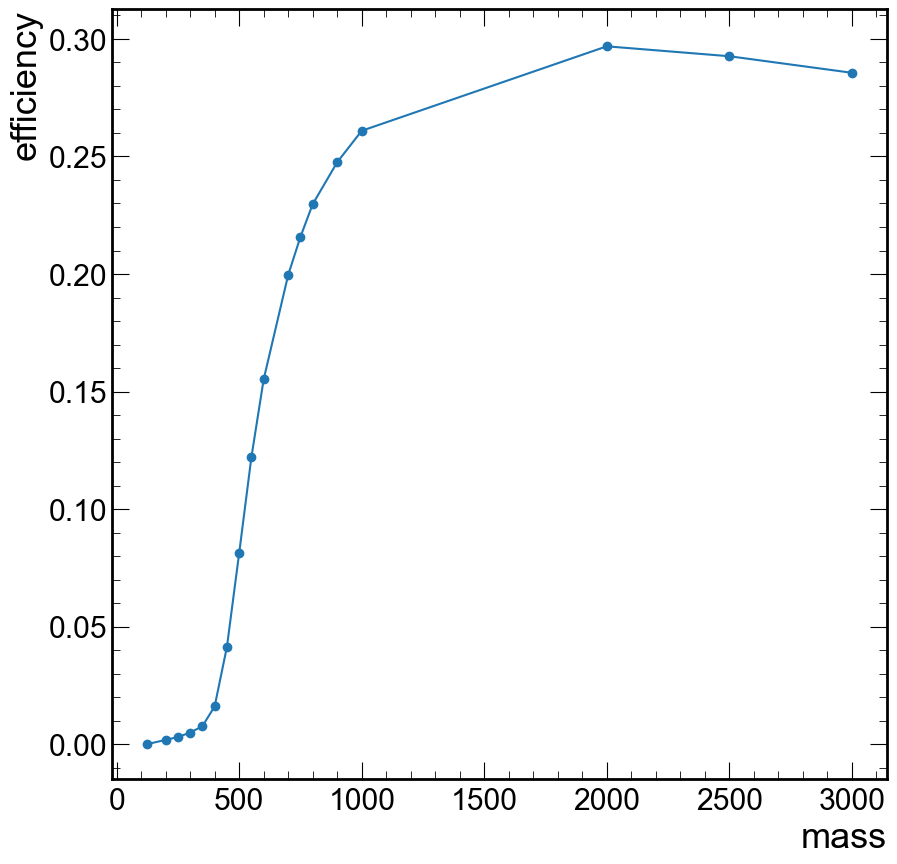

In [27]:
eff = []
eff_err_y = []
eff_err_x = []
massList = [125,200,250,300,350,400,450,500,550,600,700,750,800,900,1000,2000,2500,3000]
for sample in samples:
    #print(f'eff {sample}  = {len(arr_cut[sample].mass2lj)/n_events[sample]}')
    n_reco = len(arr_cut[sample].mass2lj)
    n_gen = n_events[sample]

    err_reco = np.sqrt(n_reco)
    err_gen = np.sqrt(n_gen)

    err_eff = np.sqrt((err_reco/n_gen)**2+(n_reco*err_gen/n_gen**2)**2)

    eff_err_y.append(err_eff)
    eff_err_x.append(0)
    eff.append(n_reco/n_gen)
    #plot eff vs mass without line with error bar
# check size of eff and massList
#print(eff)
#print(massList)
plt.errorbar(massList,eff,yerr=eff_err_y,xerr=eff_err_x,label=f'eff merged',marker='o',)
#plt.plot(massList,eff,label=f'eff_{cutcat}_{cat}_{tag}',marker='o',)
plt.xlabel('mass')
plt.ylabel('efficiency')
plt.title(f'{cutcat} {cat} {tag}')
#set legend position and size
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,prop={'size': 6})
#plt.savefig(f'eff_{cutcat}_{cat}_{tag}.png')
plt.close()

In [15]:
#len(arr['ggh200'].GEN_H1_mass)
#len(arr_cut['ggh200'].GEN_H1_mass)
#print(f'eff ggh200  = {len(arr_cut["ggh200"].GEN_H1_mass)/len(arr["ggh200"].GEN_H1_mass)}')
print(f'eff ggh200  = {len(arr_cut["ggh200"].mass2lj)/n_events["ggh200"]}')
print(f'eff ggh300  = {len(arr_cut["ggh300"].mass2lj)/n_events["ggh300"]}')

eff ggh200  = 0.0018050541516245488
eff ggh300  = 0.0048952879581151834


## compare kinematic in in control and validation region

In [10]:
#make cut 
arr_cr = {}
selection_cr = config['cut']['resolved']['CR']['2lep']['all']
for sample in samples:
    arr_cr[sample] = make_cut(selection_cr,arr[sample])

#make cut 
arr_vr = {}
selection_vr = config['cut']['resolved']['VR']['2lep']['all']
for sample in samples:
    arr_vr[sample] = make_cut(selection_vr,arr[sample])

In [9]:
#check varbs
#varb = 'KD_jjVBF' #
varb = 'pt2l' #
#fill hist
bins = 100; start = 0; stop = 1000
lumi = config['lumi']['2018']
h_cr = {}
h_vr = {}
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h_cr[sample] = hist.Hist(hist.axis.Regular(bins,start,stop))
    h_cr[sample].fill(
        arr_cut[sample][varb],
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_cut[sample])
    )
    #
    #h_vr[sample] = hist.Hist(hist.axis.Regular(bins,start,stop))
    #h_vr[sample].fill(
    #    arr_vr[sample][varb],
    #    weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_vr[sample])
    #)


In [10]:
#combine
zjet_cr = h_cr['DY_pt50To100']+h_cr['DY_pt100To250']+h_cr['DY_pt250To400']+h_cr['DY_pt400To650']+h_cr['DY_pt650ToInf']
#zjet_vr = h_vr['DY_pt50To100']+h_vr['DY_pt100To250']+h_vr['DY_pt250To400']+h_vr['DY_pt400To650']+h_vr['DY_pt650ToInf']

#ttbar_cr = h_cr["TTTo2L2Nu"]+h_cr['tZq']
#ttbar_vr = h_vr["TTTo2L2Nu"]+h_vr['tZq']
#
#zv_cr = h_cr['WZTo2Q2L']+h_cr['ZZTo2Q2L']+h_cr["WWTo2L2Nu"]
#zv_vr = h_vr['WZTo2Q2L']+h_vr['ZZTo2Q2L']+h_vr["WWTo2L2Nu"]

ggh_cr = h_cr['ggh1000']
#ggh_vr = h_vr['ggh1000']

Text(0.5, 1.0, 'ptll')

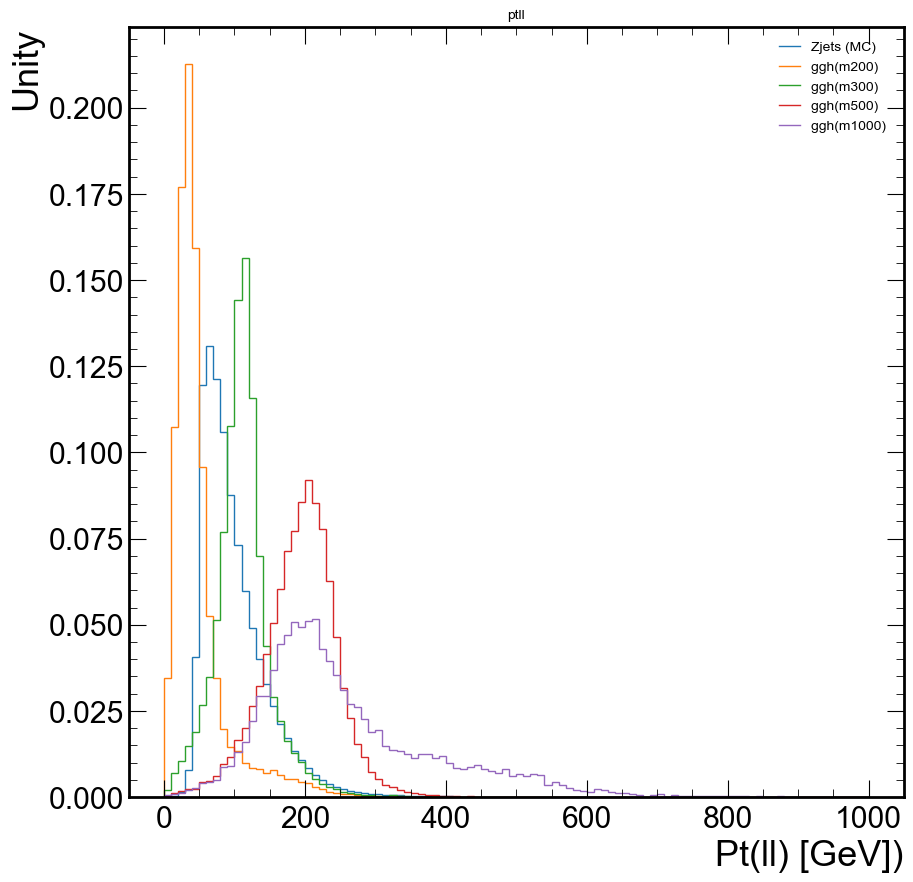

In [11]:
#plot
#hep.histplot([zjet_cr,zjet_vr],label=['zjet CR','zjet VR'], density=True,linewidth=1)
#hep.histplot([ttbar_cr,ttbar_vr],label=['ttbar,tZq CR','ttbar,tZq VR'], density=True,linewidth=1)
#hep.histplot([zv_cr,zv_vr],label=['ZV,WW CR','ZV,WW VR'], density=True,linewidth=1)
hep.histplot([zjet_cr,h_cr['ggh200'],h_cr['ggh300'],h_cr['ggh500'],h_cr['ggh1000']],label=['Zjets (MC)','ggh(m200) ','ggh(m300) ','ggh(m500) ','ggh(m1000) '], density=True,linewidth=1)
plt.xlabel('Pt(ll) [GeV])')
plt.ylabel('Unity')
plt.legend(loc='upper right',fontsize=10,fancybox=True,shadow=True)
plt.title(f'ptll',fontsize=10)
#plt.savefig(f'./plots/kd_ggh.png')

In [114]:
plt.close()

## check pt2l

In [4]:
#make cut
#siganl
selection = "(foundZ1LCandidate==True)"
#selection = "((massmerged>70) & (massmerged<105)) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True) & (particleNetZvsQCD>0.9)"
arr_cut = {}
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut[sample] = arr[sample][cut]

In [5]:
#fill hist
lumi = config['lumi']['2018']
h = {}
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h[sample] = hist.Hist(hist.axis.Regular(80, 0,800))
    h[sample].fill(
        arr_cut[sample].pt2l,
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_cut[sample])
    )

In [6]:
hist_dir = {
    'TT,tZq':h["TTTo2L2Nu"]+h['tZq'],
    #'WWTo2L2Nu':h["WWTo2L2Nu"],
    'ZV,WW':h['WZTo2Q2L']+h['ZZTo2Q2L']+h["WWTo2L2Nu"],
    'Z+jet':h['DY_pt50To100']+h['DY_pt100To250']+h['DY_pt250To400']+h['DY_pt400To650']+h['DY_pt650ToInf'] 
}

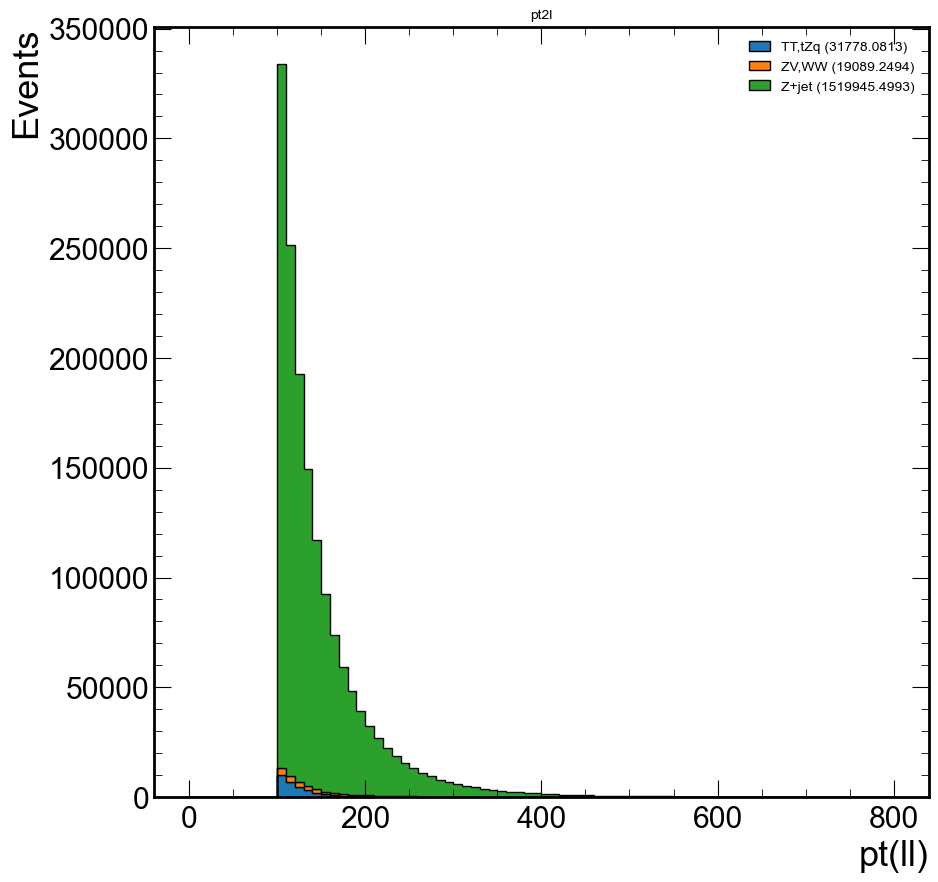

In [9]:
plot_1d_data_mc(hist_dir,'2lep')

## check 2D template

In [104]:
#make cut
#siganl
selection = "((mass2jet>70) & (mass2jet<105)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True)"
#selection = "((massmerged>70) & (massmerged<105)) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True) & (particleNetZvsQCD>0.9)"
arr_cut = {}
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut[sample] = arr[sample][cut]

In [105]:
#fill 2D
lumi = config['lumi']['2018']
temp_bin1 = np.linspace(0,1200,25)
#temp_bin2 = np.array([1300,1400,1500,1600,2000,2400,3000,3500,5000])
temp_bin2 = np.array([1300,1400,1500,1600,3500])
bins = np.concatenate((temp_bin1,temp_bin2))
massZZ_bins = hist.axis.Variable(ak.from_numpy(bins).to_list())
h = {}
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h[sample] = hist.Hist(massZZ_bins,hist.axis.Regular(10, 0, 1))
    h[sample].fill(
        arr_cut[sample].mass2l2jet,
        #arr_cut[sample].mass2lj,
        arr_cut[sample].KD_Zjj,
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_cut[sample])
        #weight=ak.ones_like(arr_cut[sample].EventWeight)
    )

In [106]:
his = h['WWTo2L2Nu'] + h['WZTo2Q2L'] + h['ZZTo2Q2L']
#his = h['DY_pt50To100'] + h['DY_pt100To250'] + h['DY_pt250To400'] +h['DY_pt400To650'] + h['DY_pt650ToInf']
#his = h['TTTo2L2Nu'] + h['tZq']
#his = h['sig']

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fab7ab71310>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fab7ab39d30>, text=[])

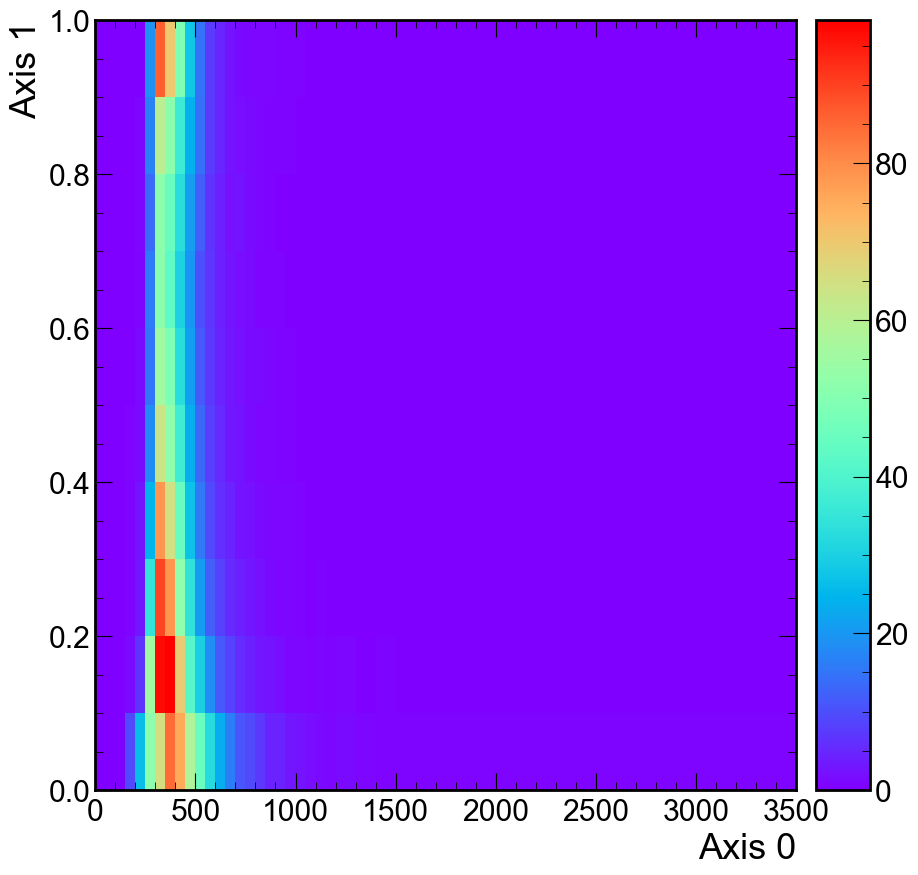

In [107]:
his.plot2d(cmap='rainbow')

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fab793d2220>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fab795287f0>, text=[])

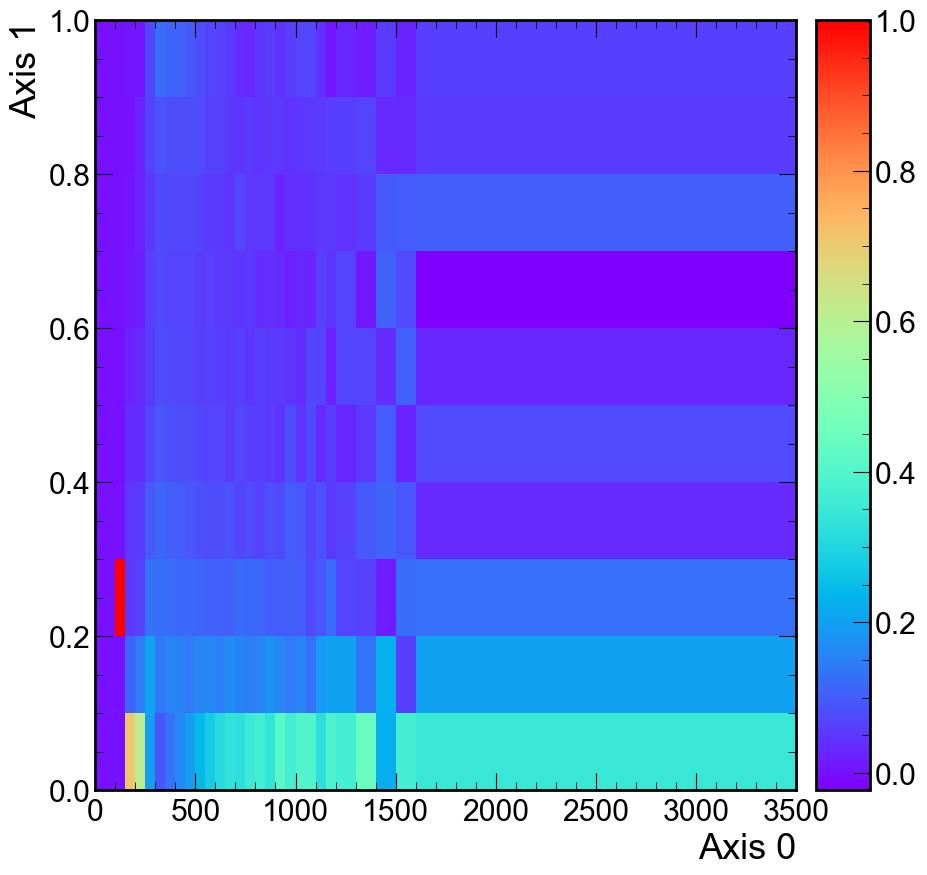

In [108]:
xbins = his.axes[0].size
h_norm = Conditional_norm_2Dhisto(his,xbins)
h_norm.plot2d(cmap='rainbow')

In [52]:
def Conditional_norm_2Dhisto(h,nbins):
    temp_h = h
    for bin in range(0,nbins):
        nevents = temp_h[bin,:].values().sum()
        if(nevents==0.0): continue
        #temp_h.view(flow=False).value[bin,:]  = np.nan_to_num(temp_h.view(flow=False).value[bin,:],0.0)
        temp_h.view()[bin,:] = temp_h.view()[bin,:]/nevents
    return temp_h

In [39]:
xbins = h.axes[0].size
h_norm = Conditional_norm_2Dhisto(h,xbins)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fab07baa1f0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fab07bb6640>, text=[])

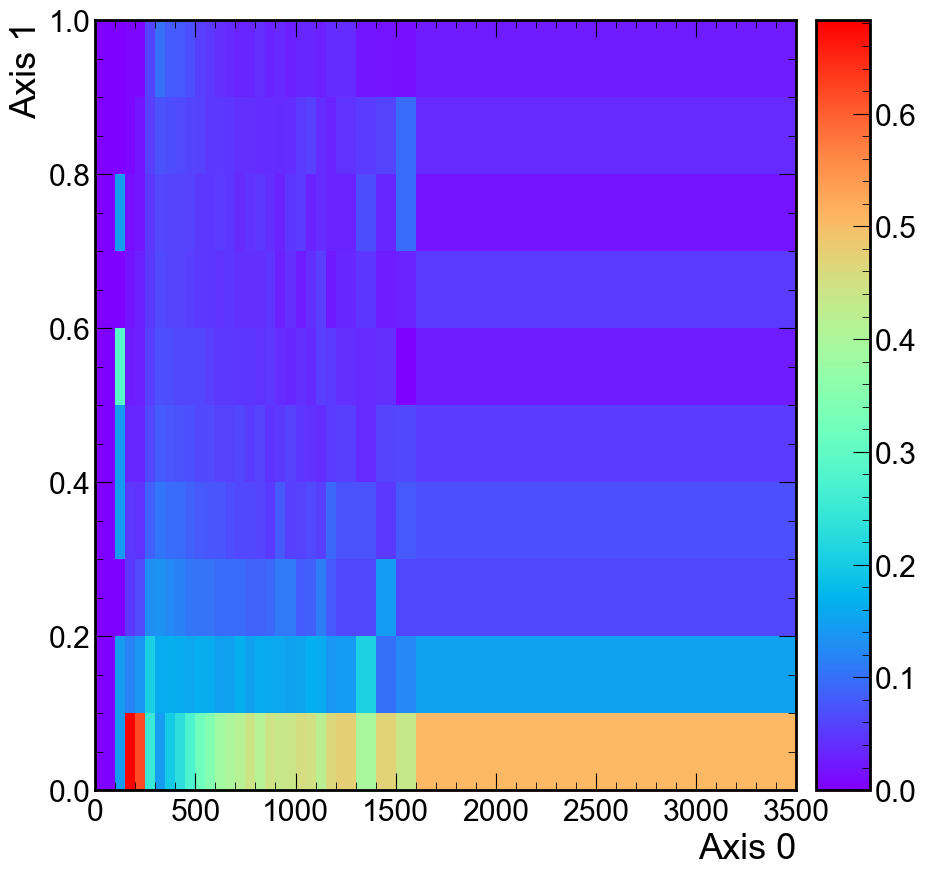

In [40]:
h_norm.plot2d(cmap='rainbow')

## Plot a 2D plot for MZZ and MJ separately in SR and SB region with signal sample

### cut on siganl and side-band region

In [10]:
#siganl
selection = "((massmerged>70) & (massmerged<105)) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True) & (particleNetZvsQCD>0.9)"
arr_cut_SR = {}
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut_SR[sample] = arr[sample][cut]
    
selection = "((massmerged<70) | (massmerged>105)) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True) & (particleNetZvsQCD>0.9)"
arr_cut_SB = {}
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut_SB[sample] = arr[sample][cut]


### Fill 2D. massZZ VS MJ histogram

In [7]:
h = hist.Hist(hist.axis.Regular(bins=50, start=500, stop=3000),hist.axis.Regular(bins=14, start=40, stop=180))
h.fill(arr_cut_SB['ggh'].mass2lj,arr_cut_SB['ggh'].massmerged)

Hist(
  Regular(50, 500, 3000, label='Axis 0'),
  Regular(14, 40, 180, label='Axis 1'),
  storage=Double()) # Sum: 186892.0 (192468.0 with flow)

Text(0, 1, 'M(J)')

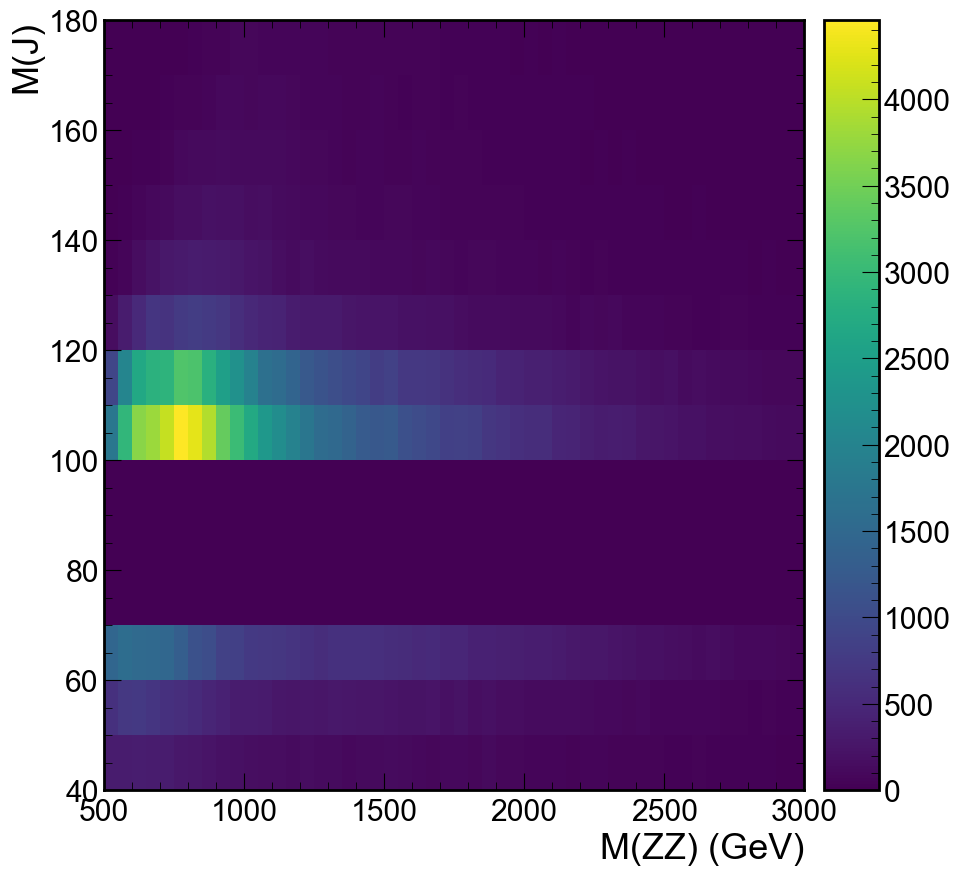

In [8]:
h.plot2d()
#set title and axis labels
plt.xlabel('M(ZZ) (GeV)')
plt.ylabel('M(J)')

##  comparison plots for the kinematics for the mZZ in the signal and sideband region.

### make cut

In [30]:
#siganl
selection = "((mass2jet>70) & (mass2jet<105)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True)"
arr_cut_SR = {}
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut_SR[sample] = arr[sample][cut]
    
selection = "((mass2jet<70) | (mass2jet>105)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True)"
arr_cut_SB = {}
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut_SB[sample] = arr[sample][cut]

### Fill Histogram for ZJet

In [42]:
lumi = config['lumi']['2018']
bins = 20; start = -5; stop = 5
#mass2l2q
h_SR = hist.Hist(hist.axis.Regular(bins=bins, start=start, stop=stop))
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h_SR.fill(arr_cut_SR[sample].eta2l2jet,
              weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_cut_SR[sample])
             )

h_SB = hist.Hist(hist.axis.Regular(bins=bins, start=start, stop=stop))
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h_SB.fill(arr_cut_SB[sample].eta2l2jet,
             weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_cut_SB[sample])
             )

Text(1, 0, 'Eta_ZZ (GeV)')

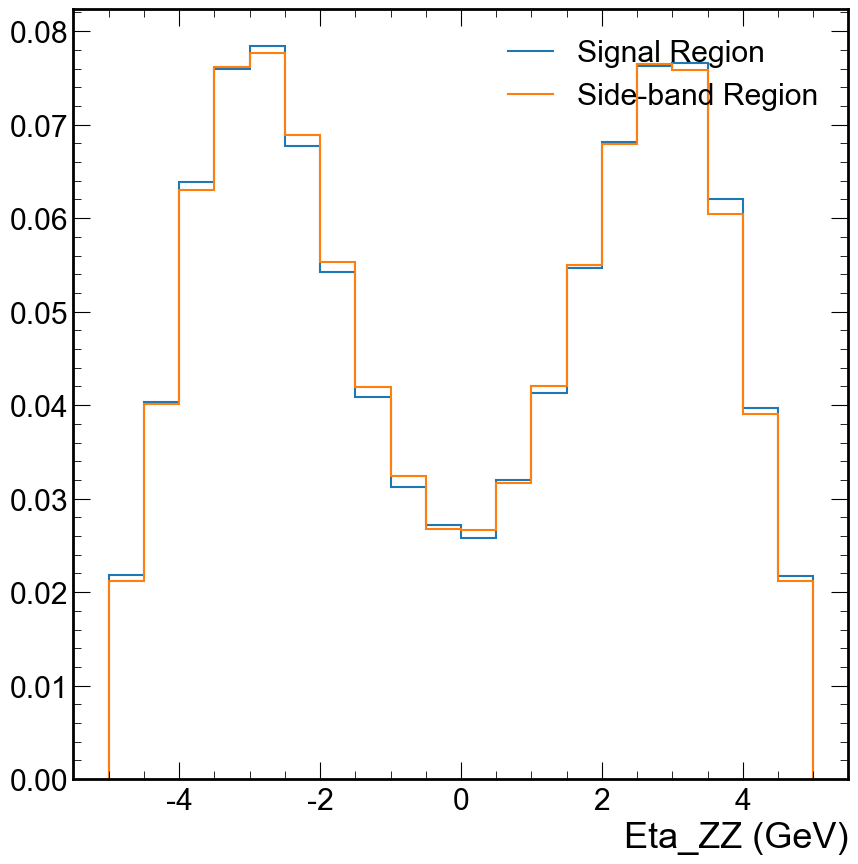

In [43]:
h_SR.plot1d(density=True,label = 'Signal Region')
h_SB.plot1d(density=True,label = 'Side-band Region')
#legend
plt.legend()
#
plt.xlabel("Eta_ZZ (GeV)")


### different pt cut 

In [5]:
### different pt cut 

#200-400
selection = "((ptmerged>200) & (ptmerged<400) & (massmerged>70) & (massmerged<105)) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)"
arr_cut_200 = {}
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut_200[sample] = arr[sample][cut]
    

#400-600
selection = "((ptmerged>400) & (ptmerged<600) & (massmerged>70) & (massmerged<105)) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)"
arr_cut_400 = {}
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut_400[sample] = arr[sample][cut]

#400-600
selection = "((ptmerged>600) & (massmerged>70) & (massmerged<105)) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)"
arr_cut_600 = {}
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut_600[sample] = arr[sample][cut]

In [33]:
#make cut
category = 'merged'
arr_cut = {}
#selection = "((mass2jet>105) & (mass2jet<135)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True)" if category == 'resolved' else "((massmerged>70) & (massmerged<105)) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)"
selection = "((mass2jet>105) & (mass2jet<135)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True)" if category == 'resolved' else "((ptmerged>600) &(massmerged>70) & (massmerged<105)) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)"
#selection = "((mass2jet>70) & (mass2jet<105)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True)" if category == 'resolved' else "((mass2jet>70) & (mass2jet<105)) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)"

#samples = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf','TTTo2L2Nu','WWTo2L2Nu','WZTo2Q2L','ZZTo2Q2L','WWTo1L1Nu2Q','tZq','ZZTo2L2Nu','WZTo1L1Nu2Q','ZH_HToBB']
#samples = ['WZTo2Q2L','ZZTo2Q2L']
for sample in samples:
    cut = ak.numexpr.evaluate(selection,arr[sample])
    arr_cut[sample] = arr[sample][cut]


In [10]:
#make hist for ZV
varb = 'particleNetZvsQCD';lumi = config['lumi'][year]

h_200 = hist.Hist(hist.axis.Regular(50, 0, 1))
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h_200.fill(arr_cut_200[sample][varb],
                   weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_cut_200[sample])
                  )

h_400 = hist.Hist(hist.axis.Regular(50, 0, 1))
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h_400.fill(arr_cut_400[sample][varb],
                   weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_cut_400[sample])
                  )

h_600 = hist.Hist(hist.axis.Regular(50, 0, 1))
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h_600.fill(arr_cut_600[sample][varb],
                   weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_cut_600[sample])
                  )


In [109]:
#fill hist
#varb = 'mass2l2jet'
varb = 'KD_Zjj'
lumi = config['lumi'][year]
edge = hist.axis.Variable([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1050., 1100., 1150., 1200., 1300., 1400.,
       1500., 1600., 2000., 2400., 3000., 3500., 5000.])

temp_bin1 = np.linspace(0,1200,25)
#temp_bin2 = np.array([1300,1400,1500,1600,2000,2400,3000,3500,5000])
temp_bin2 = np.array([1300,1400,1500,1600,3500])
bins = np.concatenate((temp_bin1,temp_bin2))
massZZ_bins = hist.axis.Variable(ak.from_numpy(bins).to_list())

h = {}
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    #h[sample] = hist.Hist(edge)
    #h[sample] = hist.Hist(setting().massZZ_bins['merged'],hist.axis.Regular(10, 0, 1))
    h[sample] = hist.Hist(massZZ_bins,hist.axis.Regular(10, 0, 1))
    h[sample].fill(arr_cut[sample]['mass2l2jet'],
                   arr_cut[sample][varb],
                   weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*{xsec}/{sumweight[sample]}',arr_cut[sample])
                  )


In [8]:
def plot_1d_data_mc(hist_dir,case,isdata = False,isdensity = False):
    r'''
        input: hist_dir, case, isdata, isdensity
        output: plot the histograms with hep.histplot
        case = 'resolved' or 'merged'
        isdata = True or False (default False)
        isdensity = True or False (default False)
    '''
    #create a list to stroe all keys in hist_dir as sample names except 'data'
    sample_names = [sample for sample in hist_dir.keys() if sample != 'data']
    #create a list to store all values in hist_dir as the histograms except 'data'
    histo_mc  = [hist_dir[sample] for sample in sample_names]
    #plot the mc histograms via hep.histplot
    #label is the list of sample names with retriving the number of events in each histogram
    #colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown','black']
    labels = ["{} ({})".format(sample,round(hist_dir[sample].values().sum(),4),'.4f') for sample in sample_names]
    if isdensity:
        #hep.histplot(histo_mc,label=labels, density=True,linewidth=1,color = [color for color in colors] )
        hep.histplot(histo_mc,label=labels, density=True,linewidth=1)
    else:
        hep.histplot(histo_mc,stack=True,label=labels,histtype='fill', edgecolor='k', linewidth=1,)
    
    if isdata:
        hep.histplot(hist_dir['Data'],label='Data', color='k', histtype='errorbar', linewidth=1.5,markersize=15)
    #set the x-axis label
    #plt.xlabel('M(2l2q) [GeV]')
    #plt.xlabel('particleNetZvsQCD')
    plt.xlabel('pt(ll)')
    #set the y-axis label
    plt.ylabel('Events')
    #set the legend
    plt.legend(loc='upper right',fontsize=10,fancybox=True,shadow=True)
    #set title with size
    #plt.title(f'Estimate M(2l2q) distribution in SR in {case} category with all possible backgrounds',fontsize=10)
    #plt.title(f'particleNetZvsQCD scroe with ZV process in pt range 600 To Inf GeV',fontsize=10)
    plt.title(f'pt2l',fontsize=10)

In [127]:
h['ggh1000'].view(flow = True)[22,:]

array([0.        , 1.63396094, 1.57335807, 1.11713383, 0.89091764,
       1.05910025, 0.82553924, 1.07044326, 1.02576179, 0.72195013,
       1.15036316, 0.        ])

In [114]:
edge = massZZ_bins
for i in range(0,len(edge)):
    hist_dir = {
        'TT,tZq':(h["TTTo2L2Nu"]+h['tZq'])[i,:],
        'ZV,WW':(h['WZTo2Q2L']+h['ZZTo2Q2L']+h["WWTo2L2Nu"])[i,:],
        'Z+jet':(h['DY_pt50To100']+h['DY_pt100To250']+h['DY_pt250To400']+h['DY_pt400To650']+h['DY_pt650ToInf'])[i,:],
        'ggH1000':(h['ggh1000'])[i,:],
        #'ggH500':(h['ggh500'])[i,:],
        #'ggH2000':(h['ggh2000'])[i,:],
        'sig':(h['sig'])[i,:],
    }
    #plot  mini_1d_hist
    plot_1d_data_mc(hist_dir,'resolved')
    plt.savefig(f'./Zjj_massZZ_resolved_{edge.edges[i]}To{edge.edges[i+1]}.png')
    plt.close()

/cms/user/guojl/miniconda/envs/uprootframe/lib/python3.8/site-packages/mplhep/utils.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(self.values))
/cms/user/guojl/miniconda/envs/uprootframe/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/cms/user/guojl/miniconda/envs/uprootframe/lib/python3.8/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/cms/user/guojl/miniconda/envs/uprootframe/lib/python3.8/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/cms/user/guojl/miniconda/envs/uprootframe/lib/python3.8/site-packages/mplhep/utils.py:245: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale
/cms/user/guojl/miniconda/envs/uprootframe/lib/python3.8/site-packages/mplhep/utils.py:263: RuntimeWarn

In [38]:
hist_dir = {
    #'TT,tZq':h["TTTo2L2Nu"]+h['tZq'],
    #'WWTo2L2Nu':h["WWTo2L2Nu"],
    #'ZV,WW':h['WZTo2Q2L']+h['ZZTo2Q2L']+h["WWTo2L2Nu"],
    #'Z+jet':h['DY_pt50To100']+h['DY_pt100To250']+h['DY_pt250To400']+h['DY_pt400To650']+h['DY_pt650ToInf'],
    #'ggH1000':h['ggh1000'],
    #'ggH500':h['ggh500'],
    #'ggH2000':h['ggh2000'],
    #'sig':h['sig'],
    #'ZH_HToBB':h['ZH_HToBB'],
    #'Data':h['Data']
    #'WWTo1L1Nu2Q':h['WWTo1L1Nu2Q'],
    #'tZq':h['tZq'],
    #'ZZTo2L2Nu':h['ZZTo2L2Nu'],
    #'WZTo1L1Nu2Q':h['WZTo1L1Nu2Q'],
    'ZV Pt(200-400 GeV)':h_200,
    'ZV Pt(400-600 GeV)':h_400,
    'ZV Pt(200-400 GeV)':h_200,
    
}

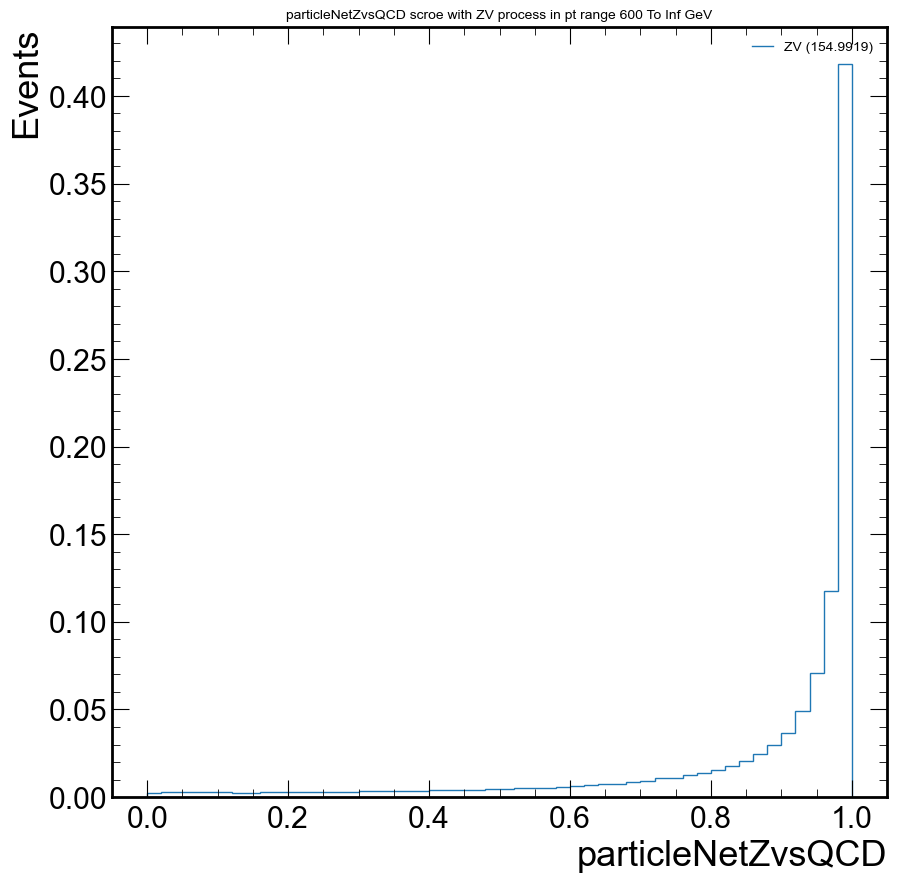

In [39]:
plot_1d_data_mc(hist_dir,'merged')

### check significance

In [56]:
hist_bkg = h["TTTo2L2Nu"]+h["WWTo2L2Nu"]+h['WZTo2Q2L']+h['ZZTo2Q2L']+h['DY_pt50To100']+h['DY_pt100To250']+h['DY_pt250To400']+h['DY_pt400To650']+h['DY_pt650ToInf']
hit_sig = h['ggh1000']

In [57]:
hit_sig.values().sum()/np.sqrt(hit_sig.values().sum()+hist_bkg.values().sum())

14.972126654316805

In [ ]:
import correctionlib

: 

In [7]:
cset = correctionlib.CorrectionSet.from_file("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/BTV/2016postVFP_UL/btagging.json.gz")
print(f'medium b-tagging deepJet WP 2016postVFP_UL: {cset["deepJet_wp_values"].evaluate("M")}')

medium b-tagging deepJet WP 2016postVFP_UL: 0.2489
